In [1]:
# Imports and path definitions

import sys
import os
import plotly.plotly as py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from itertools import combinations

path = os.getcwd() + '/'

In [2]:
#
##
### Functions
##
#
def pend(l_real, l_imag, l_projections, n):
    g = float(7)/6
    beta = 0.46686
    l_mj = []
    
    for i in l_projections:
        vec = i.split('/')
        l_mj.append(float(vec[0]))
    l = list(range(0,n))
    coef_l = []
    
    for i in l:
        x = complex(float(l_real[i]), float(l_imag[i]))    # complex
        coef_i = g*beta*(abs(x)**2)*l_mj[i]  # complex
        coef_l.append(coef_i)
    coef = sum(coef_l)
    
    return coef#, coef_l


def compare_pend(d_pends, d_eigenvectors): #d_eigenvalues
    d_dif = {}
    d_uniq = {}
    lim = 10**(-3)
    
        
    for a, b in combinations(d_pends, 2):
        #difE != 0
        # continue
        if d_eigenvectors[a] != d_eigenvectors[b]:
            value = abs(d_pends[a]- d_pends[b])

            if value < lim:
                d_dif[a + b] = value
    
    return d_dif


def sderivative(pend1, pend2, field1, field2):
    value = (float(pend1) - float(pend2)) / (float(campo1) - float(pend2))


In [86]:
##### Run at the same folder as simpre calculation (simpre.par & simpre.out needed!)

## Defined by the user so far; automatize for the future
J = float(6)
I = float(0.5)
tot_lvls = int((2*J + 1)*(2*I + 1))
m_j = list(range(int(-(2*J)), int((2*J+2)), int(2)))
m_i = list(range(int(-(2*I)), int((2*I+2)), int(2)))



## Generate projections list from m_j and m_i
projections_l = []
for j in m_j:
    for i in m_i:
        proj = str(j) + '/' + str(i)
        projections_l.append(proj)



#
## Parsing input file 'simpre.par'
#
with open(path + 'simpre.par', 'r') as par_f:
    for i in par_f:
        if 'fieldstart' in i:
            fieldstart = float(i[19 + len('fieldstart'):18 + len('fieldstart')+ 7])
        elif 'fieldend' in i:
            fieldend = float(i[19 + len('fieldend'):18 + len('fieldend')+ 7])
        elif 'fieldstep' in i:
            fieldstep = float(i[19 + len('fieldstep'):18 + len('fieldstep')+ 8])
par_f.close()


#
## Parsing input file 'simpre.out'
#
with open(path + 'simpre.out', 'r') as f:
    lines = f.read().split('\n')

c = 0
d_H = {}
H_values = []
d_eivec_pos = {}

for i in lines:
    c+=1
    if 'Magnetic Field' in i:
        vec = i.split()
        H = vec[4]
        H_values.append(H)
        d_H[H] = c
        
    elif 'Eigenvectors' in i:
        d_eivec_pos[H] = c




#
##
### Main loop
##
#
out_f1 = open(path + 'global.out', 'w')
out_f3 = open(path + 'pends.out', 'w')
out_f3.write('H_value\t')

for i in list(range(1,tot_lvls+1)):
    out_f3.write('lvl_' + str(i) + '\t')
out_f3.write('\n')



c2 = 0
for i in H_values:
    c2 += 1
    out_f1.write('#################################################\n')
    out_f1.write('## Magnetic Field value = ' + str(i) + '\n')
    out_f1.write('#################################################\n\n')
    out_f1.write('## tag   EigValues   SpinProjections   pend   EigVect(R I)\n')
    
    out_f2 = open(path + 'temp_' + str(c2) + '.out', 'w')
    out_f2.write('#################################################\n')
    out_f2.write('## Magnetic Field value = ' + str(i) + '\n')
    out_f2.write('#################################################\n\n')
    out_f2.write('## tag   EigValues   SpinProjections   pend   EigVect(R I)\n')
    
    out_f3.write(str(i) + '\t')
    
    
    d_eigenvalues = {}
    d_eigenvectors = {}
    d_pend = {}
    l_pend = []
    
    eigenvalues_list = lines[(d_H[i] + 18) : (d_H[i] + 44) ] # 18 y 44 son valores fijos 
    
    for i2 in eigenvalues_list:
        vec = i2.split()
        d_eigenvalues['lvl_' + str(vec[3])] = vec[0]
        
    eigenvectors_list = lines[d_eivec_pos[i] : d_eivec_pos[i] + tot_lvls] # tot_lvls valor variable
    
    c3 = 0
    for i3 in eigenvectors_list:
        c3 += 1
        d_eigenvectors['lvl_' + str(c3)] = i3
        
        
    for i4 in d_eigenvectors:
        vec = d_eigenvectors[i4].split()
        c_real =  vec[0::2]
        c_imag = vec[1::2]

        pend_i = pend(c_real, c_imag, projections_l,tot_lvls)
        d_pend[str(i4)] = pend_i
        l_pend.append(pend_i)
        
    
    
    ## Condition 1 : discriminates degeneracy and calculates difference between pends
    d_diffs = compare_pend(d_pend, d_eigenvalues)
    
    
    
    #### Writing temp_f and global .out
    for i in list(range(1,tot_lvls+1)):
        tag = 'lvl_' + str(i)
        out_f1.write(tag + ' ' + str(d_eigenvalues[tag]) + ' ' +  str(projections_l[i-1])
                    + ' ' + str(d_pend[tag]) + ' ' + str(d_eigenvectors[tag]) +  '\n')  # Falta Col [0/1] compare pend
        out_f2.write(tag + ' ' + str(d_eigenvalues[tag]) + ' ' +  str(projections_l[i-1])
                    + ' ' + str(d_pend[tag]) + ' ' + str(d_eigenvectors[tag]) +  '\n')  # Falta Col [0/1] compare pend
        
        out_f3.write(str(d_pend[tag]) + '\t')
    
    out_f1.write('\n\n\n')
    out_f1.write('## Differences map\n')
    out_f1.write('\n\n\n')
    
    out_f2.write('\n\n\n')
    out_f2.write('## Differences map\n')
    
    for i in d_diffs:
        out_f1.write(i + ' ' + str(d_diffs[i]) + '\n')
        out_f2.write(i + ' ' + str(d_diffs[i]) + '\n')
    
    out_f2.close()
    
    out_f3.write('\n')
    
    ## Break
    if c2 == 27:
        break


out_f1.close()
out_f3.close()


#
## Pends file
#

with open(path + 'pends.out', 'r') as pends_f:
    l = range(0,27)
    data = pd.read_csv(pends_f, sep='\t', header=0, index_col=0, dtype=float, usecols=l)

#print data


if 0.0 in data.index:
    print 'Si'
    data = data.drop([0.0])

# NEW APPROACH

** Pre analysis -- hiperfino = 0 -- control soble niveles
~ Parallel and isotrope hyperfine
Polinomios de intervalos  5/3 puntos de H

1. Run your simpre calculation and plot your results.
2. Define a trainning data set region without non-avoided crossings
    - Minimum of 3-5 points (plot your results)
3. Run Poly.py 
4. Run expected_values.py
5. Run main.py

n. of points: 206


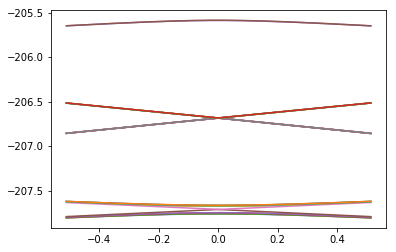

In [3]:
ene_f = path + "simpre.ene"

ene = np.loadtxt(ene_f, dtype= float)

#plt.plot(ene[:,0], ene[:,[22,23,24]])
plt.plot(ene[:,0], ene[:,1:])
#plt.savefig('plot_ene.png', dpi = 300)

print 'n. of points: ' + str(len(ene))
plt.show()


n. of points: 412


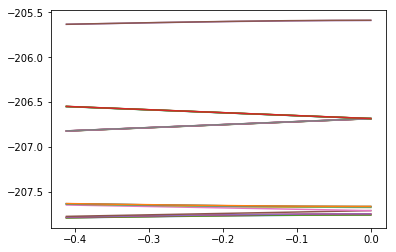

In [4]:
#
## Trainning data set
#

ene_prev_f = path + "simpre_prev.ene"
ene_prev = np.loadtxt(ene_prev_f, dtype= float)

#plt.plot(ene_prev[:,0], ene_prev[:,[1,2,3,4,5,6]])
plt.plot(ene_prev[:,0], ene_prev[:,1:])
#plt.savefig('plot_prev.png', dpi = 300)

print 'n. of points: ' + str(len(ene_prev))
plt.show()

In [3]:
#
## Initial definitions
#

# Defined by the user so far; automatize for the future
J = float(6)
I = float(0.5)

# Lists
tot_lvls = int((2*J + 1)*(2*I + 1))
m_j = list(range(int(-(2*J)), int((2*J+2)), int(2)))
m_i = list(range(int(-(2*I)), int((2*I+2)), int(2)))

## Generate projections list from m_j and m_i
projections_l = []
for j in m_j:
    for i in m_i:
        proj = str(j) + '/' + str(i)
        projections_l.append(proj)


In [4]:
#
## Adjust levels to a polinomial expression module
#

poli_out = open(path + 'poli.out', 'w')
ene_p_f = path + "simpre_prev.ene"


# Convert ene to an array (ene) and then to a DF (ene_df)
ene_p = np.loadtxt(ene_p_f, dtype= float)

lvls_list = []
for i in list(range(np.size(ene_p, axis=1)-1)):
    lvls_list.append('lvl_'+ str(i+1))

ene_p_df = pd.DataFrame(data=ene_p[0:,1:],  index=ene_p[0:,0] , columns=lvls_list)
print len(ene_p_df)


#
## Defining polynomia from Prev dataset. 
# One should run a pre-calculation in order to adjust correctly each level.

poli_out.write('name\tk0\tk1\tk2\n')
c = 0 

for i in ene_p_df:
    #print i
    c += 1
    x = ene_p_df.index#[0:5]
    y = ene_p_df[i]#.iloc[0:5]
    z = np.polyfit(x, y, deg = 2)
    #print x
    
    k0 = z[2]
    k1 = z[1]
    k2 = z[0]
    
    if abs(z[0]) > abs(z[1]):
        m = 'second order is higher'
    else:
        m = 'first order is higher'
    
    p = np.poly1d(z)
    
    poli_out.write(i + '\t' + str(k0) + '\t' + str(k1) + '\t' + str(k2))
    poli_out.write('\n')

poli_out.close()

412


In [5]:
#
##
### Loading datasets
##
#

# Loads polynomios file
with open(path + 'poli.out', 'r') as poli_f:
    poli_df = pd.read_csv(poli_f, sep='\t', header=0, index_col=0)#, dtype=float)


# Loads new 'simpre.ene' file with energies of each level (quantum number) at diff H field
with open(path + 'simpre.ene', 'r') as ene_f:
    ene = np.loadtxt(ene_f, dtype= float)
    ene_df = pd.DataFrame(data=ene[0:,1:],  index=ene[0:,0] , columns=lvls_list)

if float(0.0) in ene_df.index:
    ene_df = ene_df.drop([0.0])
    


#
##
### Prediction of points
##
#

# Creating an empty DF for further lvl ordering
H_values = ene_df.index
index = H_values
columns = lvls_list
order_df = pd.DataFrame(index=index, columns=columns)



expected_values = {}


#
## Main loop
#

expec_out = open('expected_values.out', 'w')

c = 0
c4 = 0


for i in H_values:
    c += 1
    
    expec_out.write(str(i) + '\t')    
    expected_v = []
    d_code = {}
    
    
    for i2 in lvls_list:
        if c == 1:
            order_df.loc[i, i2] = i2
            continue
        
        elif abs(poli_df.loc[i2, 'k1']) > abs(poli_df.loc[i2, 'k2']):
            #print i + ' line'
            d_code[i2] = 'line'
            
            k0 = poli_df.loc[i2, 'k0']
            k1 = poli_df.loc[i2, 'k1']
            k2 = poli_df.loc[i2, 'k2']

            predicted_E = (k2 * (float(i)**2)) + (k1 * float(i)) + k0
            v = '%.6f' % predicted_E
            expected_v.append(v)
            expec_out.write(str(v) + '\t')
            
            #print ene_df.loc[i].index
            
            c4 = 0
            for e1 in ene_df.loc[i]:
                e1_0 = '%.6f' % e1
                e1_1 = '%.5f' % e1
                v_1 = '%.5f' % float(v)
                e1_2 = '%.4f' % e1
                v_2 = '%.4f' % float(v)
                #e1_3 = '%.3f' % e1
                #v_3 = '%.3f' % float(v)
                
                c4+=1
                
                if e1_0 == v:
                    order_df.loc[i, i2] = 'lvl_' + str(c4)
                elif e1_1 == v_1:
                    order_df.loc[i, i2] = 'lvl_' + str(c4)
                elif e1_2 == v_2:
                    order_df.loc[i, i2] = 'lvl_' + str(c4)
                #elif e1_3 == v_3:
                #    order_df.loc[i, i2] = 'lvl_' + str(c4)
                else:
                    order_df.loc[i, i2]
         
        
        elif abs(poli_df.loc[i2, 'k1']) < abs(poli_df.loc[i2, 'k2']):
            d_code[i2] = 'curve'
            order_df.loc[i, i2] = i2

    #expected_values[i] = expected_v
    expec_out.write('\n')

    
order_df.to_csv(path + 'order.txt', header = None, sep='\t', mode = 'a', na_rep='na')   
expec_out.close()

#print order_df
#print ene_df



    
## Condition 1 : compare pends (k1)
   
## Condition 2 : compare second derivative (k2)
    
## Condition 3 : allowed/non-allowed transitions (+/- 1) 

In [21]:
print order_df.iloc[0]

lvl_1      lvl_1
lvl_2      lvl_2
lvl_3      lvl_3
lvl_4      lvl_4
lvl_5      lvl_5
lvl_6      lvl_6
lvl_7      lvl_7
lvl_8      lvl_8
lvl_9      lvl_9
lvl_10    lvl_10
lvl_11    lvl_11
lvl_12    lvl_12
lvl_13    lvl_13
lvl_14    lvl_14
lvl_15    lvl_15
lvl_16    lvl_16
lvl_17    lvl_17
lvl_18    lvl_18
lvl_19    lvl_19
lvl_20    lvl_20
lvl_21    lvl_21
lvl_22    lvl_22
lvl_23    lvl_23
lvl_24    lvl_24
lvl_25    lvl_25
lvl_26    lvl_26
Name: -0.51099998, dtype: object


In [21]:
#print order_df

for i 


for i in H_values:
    for j in lvls_list:
        
        lab = order_df.loc[i,j]
        
        if lab == 'NaN':
            df_final.loc[i,j] = 0
            
        else:
            label = order_df.loc[i,j]
            lab = int(label.replace('lvl_', ''))
            j = int(label.replace('lvl_', ''))
            print lab
            
            if lab == j+1:
                df_final.loc[i,j] = ene_df.loc[i,j]
            else:
                df_final.loc[i,j] = ene_df.loc[int(i),int(lab)] 

print df_final.shape         


df = pd.DataFrame(df_final)
#np.savetxt(path + 'final.txt', df_final, delimiter=' ', newline='\n')
df.to_csv(path + 'final.txt', header = None, sep='\t', mode = 'a', na_rep='na')


lvl_1
1


KeyError: u'the label [0] is not in the [index]'

In [22]:
expec_f = path + "expected_values.out"
expec = np.loadtxt(expec_f, dtype= float)

plt.plot(ene[:,0], ene[:,1:])
plt.plot(expec[:,0], expec[:,[1,2,3,4,5,6,7]])
#plt.plot(ene[:,0], ene[:,[18,19]])
print 'n. of points: ' + str(len(expec))
plt.show()
#plt.savefig('plot_prev.png', dpi = 300)


ValueError: Wrong number of columns at line 2

In [98]:
#
##
### Slope calculation module from eigenvalues and eigenvectors
##
#

#
## Parsing input file 'simpre.out'
#
with open(path + 'simpre.out', 'r') as f:
    lines = f.read().split('\n')


out_f1 = open(path + 'global.out', 'w')
out_f3 = open(path + 'pends.out', 'w')
out_f3.write('H_value\t')

for i in list(range(1,tot_lvls+1)):
    out_f3.write('lvl_' + str(i) + '\t')
out_f3.write('\n')


d_H = {}
H_values = []
d_eivec_pos = {}


c = 0
for i in lines:
    c+=1
    if 'Magnetic Field' in i:
        vec = i.split()
        H = vec[4]
        H_values.append(H)
        d_H[H] = c
        
    elif 'Eigenvectors' in i:
        d_eivec_pos[H] = c


c2 = 0
for i in H_values:
    c2 += 1
    out_f1.write('#################################################\n')
    out_f1.write('## Magnetic Field value = ' + str(i) + '\n')
    out_f1.write('#################################################\n\n')
    out_f1.write('## tag   EigValues   SpinProjections   pend   EigVect(R I)\n')
    
    out_f2 = open(path + 'temp_' + str(c2) + '.out', 'w')
    out_f2.write('#################################################\n')
    out_f2.write('## Magnetic Field value = ' + str(i) + '\n')
    out_f2.write('#################################################\n\n')
    out_f2.write('## tag   EigValues   SpinProjections   pend   EigVect(R I)\n')
    
    out_f3.write(str(i) + '\t')
    
    
    d_eigenvalues = {}
    d_eigenvectors = {}
    d_pend = {}
    l_pend = []
    
    eigenvalues_list = lines[(d_H[i] + 18) : (d_H[i] + 44) ] # 18 y 44 son valores fijos 
    
    for i2 in eigenvalues_list:
        vec = i2.split()
        d_eigenvalues['lvl_' + str(vec[3])] = vec[0]
        
    eigenvectors_list = lines[d_eivec_pos[i] : d_eivec_pos[i] + tot_lvls] # tot_lvls valor variable
    
    c3 = 0
    for i3 in eigenvectors_list:
        c3 += 1
        d_eigenvectors['lvl_' + str(c3)] = i3
        
    
    
    #
    ## Calculates slopes
    #
    for i4 in d_eigenvectors:
        vec = d_eigenvectors[i4].split()
        c_real =  vec[0::2]
        c_imag = vec[1::2]

        pend_i = pend(c_real, c_imag, projections_l,tot_lvls)
        d_pend[str(i4)] = pend_i
        l_pend.append(pend_i)
        

    ## Condition 1 : discriminates degeneracy and calculates difference between pends
    d_diffs = compare_pend(d_pend, d_eigenvalues)
    
    
    
    #### Writing temp_f and global .out
    for i in list(range(1,tot_lvls+1)):
        tag = 'lvl_' + str(i)
        out_f1.write(tag + ' ' + str(d_eigenvalues[tag]) + ' ' +  str(projections_l[i-1])
                    + ' ' + str(d_pend[tag]) + ' ' + str(d_eigenvectors[tag]) +  '\n')  # Falta Col [0/1] compare pend
        out_f2.write(tag + ' ' + str(d_eigenvalues[tag]) + ' ' +  str(projections_l[i-1])
                    + ' ' + str(d_pend[tag]) + ' ' + str(d_eigenvectors[tag]) +  '\n')  # Falta Col [0/1] compare pend
        
        out_f3.write(str(d_pend[tag]) + '\t')
    
    
    
    out_f1.write('\n\n\n')
    out_f1.write('## Differences map\n')
    out_f1.write('\n\n\n')
    
    out_f2.write('\n\n\n')
    out_f2.write('## Differences map\n')
    
    for i in d_diffs:
        out_f1.write(i + ' ' + str(d_diffs[i]) + '\n')
        out_f2.write(i + ' ' + str(d_diffs[i]) + '\n')
    
    out_f2.close()
    
    out_f3.write('\n')
    
    
    
    ## Break
    if c2 == 47:
        break



out_f1.close()
out_f3.close()

